# Trabajo Final de Graduación
Daniel Núñez Vargas

In [1]:
import matplotlib.pyplot as plt
from Funciones import normalize_block_name, limpiar_entorno # Script donde se han incluido variedad de funciones personalizadas
import pandas as pd
import numpy as np
import re
import os
import geopandas as gpd
import contextily as ctx
from shapely.geometry import Point

In [2]:
# Carga de los datos
gdf = gpd.read_file("../Input/Incidents_2025.shp") # Cartografía de los datos

Haciendo un plot sobre la cartografía consultada:

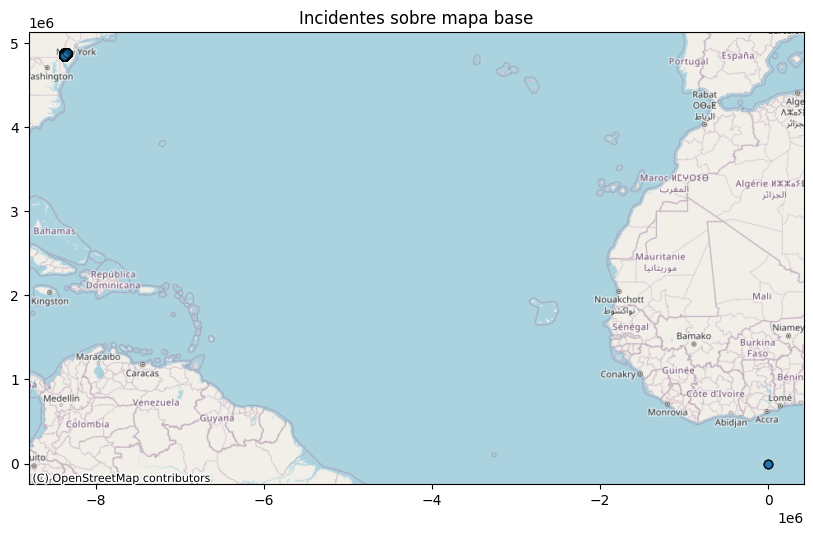

In [3]:
gdf = gdf.to_crs(epsg=3857)

ax = gdf.plot(figsize=(10, 10), edgecolor='black', alpha=0.5)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
plt.title("Incidentes sobre mapa base")
plt.show()

Notamos la particularidad de que hay varios puntos en la coordenada (0, 0), lo cual no hace sentido; muy probablemente son valores vacíos/atípicos que deberán ser tratados correctamente.

In [4]:
# 1. Convertir a DataFrame
df_pandas = gdf.copy()
df_pandas['longitude'] = gdf.geometry.x
df_pandas['latitude'] = gdf.geometry.y
df_pandas = df_pandas.drop(columns=['geometry'])

Antes de proceder con la imputación, primero observamos que la nube de puntos cercana a la coordenada (0,0) corresponden a las primeras observaciones mostradas en la siguiente tabla. 

In [5]:
df_pandas.sort_values('latitude').head(10)[['objectid', 'latitude', 'longitude']]

,objectid,latitude,longitude
43311,27941483,6.327780e-09,6.327780e-09
42126,27861562,6.327780e-09,6.327780e-09
43143,27632545,6.327780e-09,6.327780e-09
29993,29869620,6.327780e-09,6.327780e-09
170,29086867,6.327780e-09,6.327780e-09
163,29086859,6.327780e-09,6.327780e-09
81307,25804588,4.848128e+06,-8.376593e+06
10944,29853813,4.848128e+06,-8.376593e+06
38522,29873163,4.848128e+06,-8.376593e+06
59875,27383504,4.848349e+06,-8.376028e+06


In [6]:
# Primero hallemos el valor mínimo para la latitud, quitando estos outliers
min_lat = df_pandas[df_pandas['latitude'] > 1][['latitude']].min()
# Ahora hallamos el valor máximo para la longitud, quitando los outliers
max_lon = df_pandas[df_pandas['longitude'] < -1][['longitude']].max()
# Se define la conficion
condicion = (df_pandas['latitude'] <= min_lat['latitude']) | (df_pandas['longitude'] >= max_lon['longitude'])
# Asignar cero a los registros que cumplan la condición
df_pandas.loc[condicion, ['latitude', 'longitude']] = np.nan

print(f"Registros modificados: {condicion.sum()}")

Registros modificados: 8


In [7]:
# Se filtran aquellas observaciones que no tienen algunas de las coordenadas
df_nan = df_pandas[(df_pandas['latitude'].isna()) | (df_pandas['longitude'].isna())]
# Ahora se extren las ubicaciones de manera única
location_blocks_nan = df_nan['location_b'].unique()

df_temp = df_pandas[df_pandas['location_b'].str.contains(
    r'1900\s+block\s+s\s+christopher\s+columbus', 
    case=False, na=False
)]

print(df_temp[['location_b', 'latitude', 'longitude']].head(2))

                                 location_b      latitude     longitude
134   1900 BLOCK S CHRISTOPHER COLUMBUS BLV           NaN           NaN
230  1900 BLOCK S CHRISTOPHER COLUMBUS BLVD  4.854639e+06 -8.364811e+06


Notamos algo interesante ya que para un registro sí se tienen coordenadas de ese bloque mientras que para otro no, siendo la única diferencia entre registros la palabra "BLVD". Este compartamiento se repite para miles de observaciones, por lo que el primer paso será depurar la variable location_block, ya que esta nos permitirá realizar la imputación basándonos en el bloque en el ocurrió el delito.

In [8]:
df_pandas['location_block_normalized'] = df_pandas['location_b'].apply(normalize_block_name)

Ahora examinamos la cardinalidad de las variables latitud y longitud, por bloque: 

In [9]:
coordinates_info_by_block = (df_pandas.groupby(['location_block_normalized']).agg(
    unique_latitudes=('latitude', 'nunique'),
    unique_longitudes=('longitude', 'nunique')
)).sort_values(by = 'unique_latitudes', ascending=False)
print(coordinates_info_by_block.head(5))

                           unique_latitudes  unique_longitudes
location_block_normalized                                     
4000 BLOCK LANCASTER AVE                 38                 38
GERMANTOWN AVE                           36                 37
N BROAD ST                               33                 33
FRANKFORD AVE                            32                 32
2800 BLOCK KENSINGTON AVE                31                 31


Como se observa en el cuadro anterior, un bloque puede tener más de una latitud y longitud. Esto sucede porque los bloques fueron redondeados al bloque de cien más cercano. Tomemos el caso que presenta mayor cardinalidad para efectos de la explicación, el cual es **4000 BLOCK LANCASTER AVE**. 

Si tomamos todas las longitudes y latitudes para este bloque, y se calcula el mínimo y el máximo nos damos cuenta que realmente todos lo registros en latitud están entre los 39.9631° y los 39.9652°. De manera análoga para longitud, ubicando todos los crímenes entre los -75.2055° y los -75.2026°.

In [10]:
df_temp = df_pandas[df_pandas['location_block_normalized'] == '4000 BLOCK LANCASTER AVE'][['location_block_normalized', 'latitude', 'longitude']]
print(df_temp['latitude'].quantile([0,1]).round(4))
print(df_temp['longitude'].quantile([0,1]).round(4))

0.0    4.860581e+06
1.0    4.860893e+06
Name: latitude, dtype: float64
0.0   -8.371838e+06
1.0   -8.371521e+06
Name: longitude, dtype: float64


Aunque existan diferentes longitudes y latitudes para un mismo bloque, este hallazgo lo que nos indica es que la diferencia en términos de grados es marginal por lo que para efectos de hacer imputación para aquellos registros que no tienen coordenadas, se tomará el primer set de coordenadas encontradas para dicho bloque. 

In [11]:
# Extraemos los registros que NO tienen missing en sus coordenadas
df_non_nan_unique = (
    df_pandas[~(df_pandas['latitude'].isna() | df_pandas['longitude'].isna())]
    .sort_values('dispatch_d')  # opcional: para priorizar por fecha
    .drop_duplicates(subset='location_block_normalized', keep='first')
    [['location_block_normalized', 'latitude', 'longitude']]
)
# Se filtran aquellas observaciones que SÍ tienen missing en sus coordenadas
df_nan_clean = df_pandas[(df_pandas['latitude'].isna()) | (df_pandas['longitude'].isna())].drop(['latitude', 'longitude'], axis=1)
# Se procede a hacer el leftjoin entre ambos datasets
df_nan_join = df_nan_clean.merge(
    df_non_nan_unique,
    on='location_block_normalized',
    how='left',
)

Así que de las 3154 variables que en un inicio tenía sus coordenadas como valores vacíos, mediante esta técnica de imputación se logró reducir ese número a tan solo 434 registros. Dentro de estos encontramos casos como el de **6500 BLOCK HAVERFORD** el cual no tiene ninguna coicidencia cercana respecto a los otros bloques. 

In [12]:
# Se filtran aquellas observaciones que no desde un inicio no tenias las coordenadas vacias
df_non_nan = df_pandas[~(df_pandas['latitude'].isna() | df_pandas['longitude'].isna())]
# Se calcula la cantidad de registros que tienen coincidencia con el bloque 6500 BLOCK HAVERFORD
len(df_non_nan[df_non_nan['location_block_normalized'].str.contains('6500 BLOCK HAVERFORD')])

0

Imputar el resto de observaciones implica un análisis individualizado, sin embargo, es más el costo en el que se incurriría que el simple hecho de descartarlas para efectos del trabajo propuesto, ya que solo representan un 0.52% del número total de registros.

In [13]:
# Se filtran las variables de interes 
df_nan_filled = df_nan_join[['latitude', 'longitude', 'hour', 'dispatch_1', 'dc_dist', 'psa', 'ucr_genera', 'text_gener', 'location_b', 'location_block_normalized']]
# Se unen ambos dataframes (El original que no tenías las coordenadas en cero + observaciones imputadas)
df_non_nan_gps = pd.concat([df_non_nan, df_nan_filled]).dropna(subset=['latitude', 'longitude'])
# Se filtran aquellas observaciones que aún se mantienen como vacías
df_still_nan = df_nan_join[df_nan_join['latitude'].isna() | df_nan_join['longitude'].isna()]
round(len(df_still_nan)/len(df_non_nan_gps)*100,2)

0.52

In [14]:
# Lista de variables a borrar para mantener limpio el ambiente
variables_a_borrar = ['coordinates_info_by_block', 'df', 'df_pandas', 'df_nan', 'df_nan_clean', 
                      'df_nan_filled', 'df_nan_join', 'df_non_nan', 'df_non_nan_unique', 'condicion'
                      'location_blocks_nan', 'max_lon', 'min_lat', 'df_still_nan', 'df_temp', 
                      'location_blocks_nan' 'var', 'var_name', 
                      'variables_a_borrar']
for var_name in variables_a_borrar:
   if var_name in globals():
       del globals()[var_name]

# Se descartan varias variables que no aportan valor agregado
df_non_nan_gps = df_non_nan_gps.drop(['objectid', 'dispatch_d', 'dispatch_t', 'dc_key', 'location_b', 'point_x',
       'point_y'], axis=1)

In [15]:
# Crear geometría desde las coordenadas
geometry = [Point(lon, lat) for lon, lat in zip(df_non_nan_gps['longitude'], df_non_nan_gps['latitude'])]

gdf_fill_na = gpd.GeoDataFrame(
    df_non_nan_gps.drop(columns=['longitude', 'latitude']),  # Quitar coords si no las necesitas
    geometry=geometry,
    crs=gdf.crs  # Mantener el mismo sistema de coordenadas
)


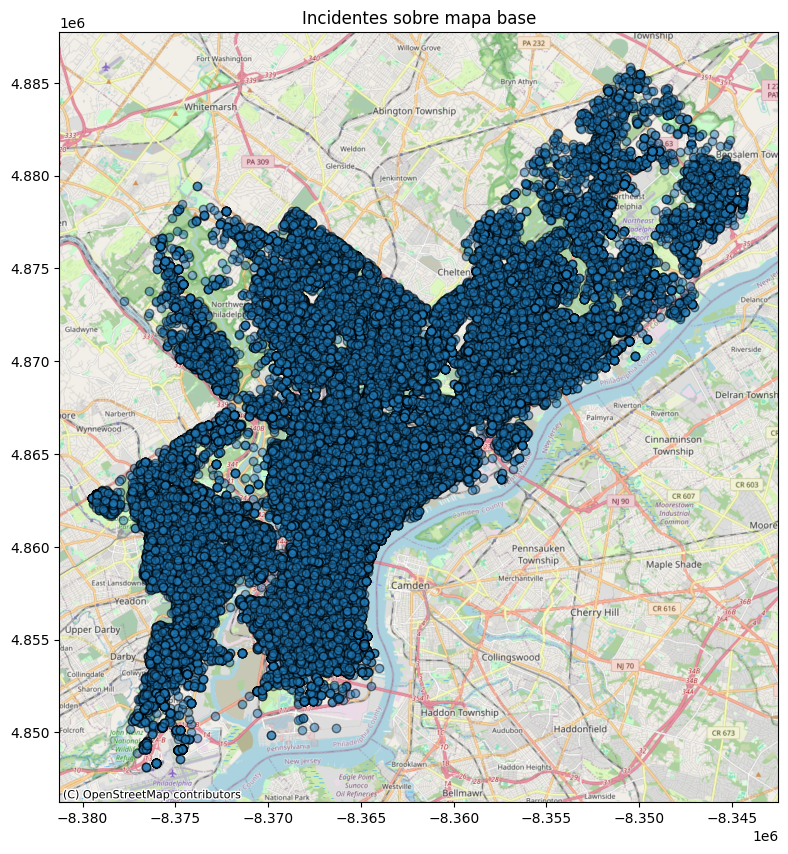

In [16]:
gdf_fill_na = gdf_fill_na.to_crs(epsg=3857)

ax = gdf_fill_na.plot(figsize=(10, 10), edgecolor='black', alpha=0.5)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
plt.title("Incidentes sobre mapa base")
plt.show()